#  Test integer observable training

This notebook is used to test that the code can handle integer observables. It is used to check for bugs after code updates.

### 0.  Import framework objects

In [1]:
#  Required imports

print("Importing standard library")
import os, sys, time

print("Importing python data libraries")
import numpy as np
from   matplotlib import pyplot as plt, colors
from   scipy      import stats

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model


Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


### 1. Set up a toy model to generate data from

In [2]:
#  Inputs config

c_vals      = np.array([0, -10, -5, -1, 1, 5, 10], dtype=float)
num_samples = int(1e4)
    

In [3]:
#  Toy model

def PDF (x, c) :
    c = np.fabs(c) + 3
    return stats.poisson.pmf(x-5, c)
    
def CDF (x, c) :
    c = np.fabs(c) + 3
    return stats.poisson.cdf(x-5, c)
    
def generate (num_samples, c) :
    if type(c) in [list, np.ndarray] :
        return [generate(num_samples, cp) for cp in c]
    return np.random.choice(np.linspace(0., 99., 100), size=(int(num_samples),), p=PDF(np.arange(100), c)).reshape([-1,1])


In [4]:
#  Generate training data

initial_data = {c:generate(num_samples, c) for c in c_vals}
weights      = {c:np.ones(shape=(num_samples,)) for c in c_vals}


In [5]:
#  Get data range

def get_min (obj) :
    try : return np.min([get_min(o) for o in obj])
    except : pass
    return obj

def get_max (obj) :
    try : return np.max([get_max(o) for o in obj])
    except : pass
    return obj
    
def get_minmax (obj) :
    return get_min(obj), get_max(obj)
    
x_min, x_max = get_minmax([i for c,i in initial_data.items()])

print(f"Observable limits are [{x_min:.0f}, {x_max:.0f}]")


Observable limits are [5, 35]


---

# Test 1: create, train, evaluate, sample

Create an integer probability model using the DensityModel class. Train it, then pass some datapoints through for evaluation. Evaluate using the Numpy wrapper (slow) and explicit TF model (fast), and show that they are the same.

---

In [6]:
#
#   Create density model  
#
density_model = DensityModel(name               = "S", 
                             num_gaussians      = 2, 
                             num_conditions     = 1, 
                             num_observables    = 1, 
                             types              = [int],
                             verbose            = True,
                             learning_rate      = 0.001,
                             optimiser          = "adam",
                             observables_limits = [[x_min, x_max]],
                             condition_limits   = [[np.min(c_vals), np.max(c_vals)]],
                             bias_initializer         = "zeros",
                             activation               = "leakyrelu",
                             A1                       = 5,
                             A2                       = 5,
                             B1                       = 5,
                             B2                       = 5,
                             C_int                    = [32, 32],
                             transform_min            = -2.,
                             transform_max            = 2.)
               

INFO       DensityModel.construct      Set model name              : S
INFO       DensityModel.construct      Set model num_gaussians     : 2
INFO       DensityModel.construct      Set model num_conditions    : 1
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'int'>]
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.2
INFO       DensityModel.build          Building model segment: S_observable0 for observable index 0
Projecting row index 0 from interval [-10.0, 10.0] onto [-2.0, 2.0]
Creating continuous density model: S_observable0
  - num_conditions_in        is 1
  - 

In [7]:
#
#   Make sure initial state does not evaluate to Inf or NaN
#
density_model.ensure_valid_over_dataset (initial_data, weights)
                      

W0224 16:45:23.790583 4486178240 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Evaluating losses
-  observable logL are [-379958.11760718], combined is -379958.1176071763
-  eval completed in 0s


In [8]:
#
#   Fit density model
#
density_model.fit(initial_data , 
                  weights      ,
                  max_epochs_per_observable = 1000,
                  early_stopping_patience   = 10  ,
                  early_stopping_min_delta  = 0   ,
                  validation_split          = -1  ,
                  batch_size_per_observable = 300 )


INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 300
INFO       DensityModel.fit              -  Training setting: validation_split = -1
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 70000 samples
Epoch 1/1000
70000/70000 [==============================] - 0s 3us/sample - loss: 3.1030
Epoch 2/1000
70000/70000 [==============================] - 0s 3us/sample - loss: 2.4088
Epoch 3/1000
70000/70000 [==============================] - 0s 3us/sample - loss: 2.3632
Epoch 4/1000
70000/70000 [==============================] - 0s 4us/sam

In [9]:
#  Check that evaluator model gives same result as prediction followed by manual calculation

test_data = initial_data[0.]

logL1 = np.log(density_model.evaluate(0, test_data))[:,0]
logL2 = density_model.split_evaluator.predict([np.full(fill_value=0., shape=(num_samples,1)), test_data])[:,0]

print(f"c=0. with method 1 returns {np.mean(logL1):.3f} +/- {np.std(logL1):.3f}")
print(f"c=0. with method 2 returns {np.mean(logL2):.3f} +/- {np.std(logL2):.3f}")
print(f"the ratio is {np.mean(logL2/logL1):.3f} +/- {np.std(logL2/logL1):.3f}")


c=0. with method 1 returns -1.931 +/- 0.674
c=0. with method 2 returns -1.931 +/- 0.674
the ratio is 1.000 +/- 0.000


In [10]:
#  Sample datapoints from the trained model

sampled_data = {}
for c in sorted(c_vals) :
    sampled_data[c] = density_model.sample(int(1e5), c).flatten()


INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0
INFO       DensityModel.sample         Sampling 100000 datapoints, observable index is 0


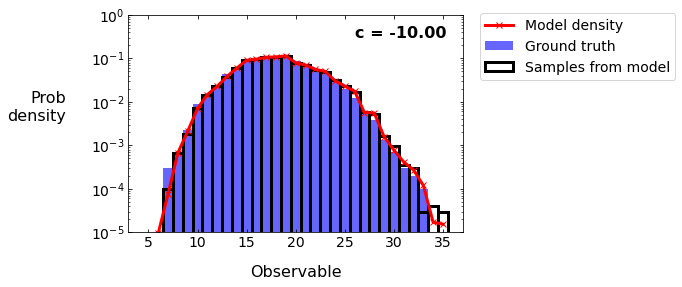

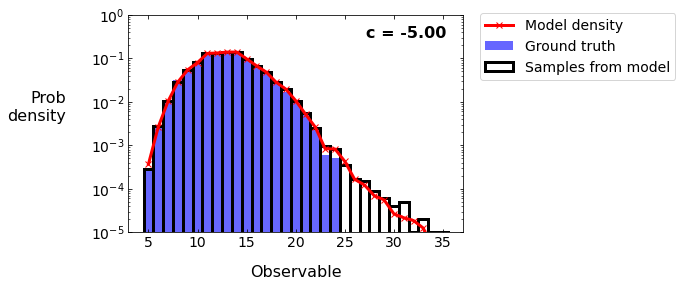

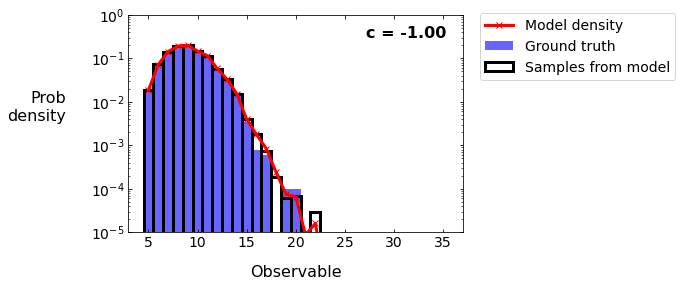

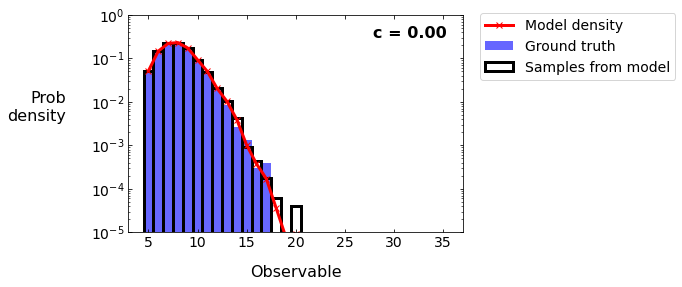

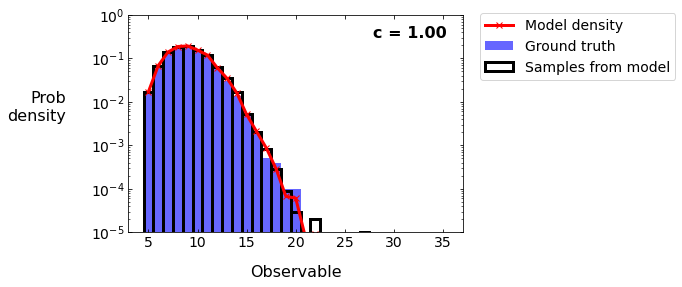

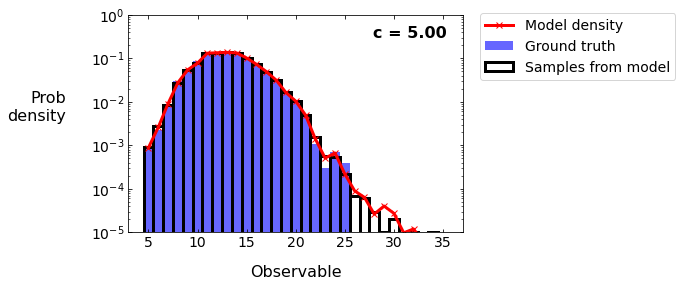

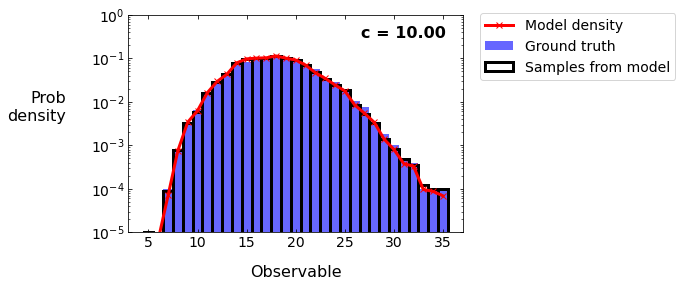

In [11]:
#  Plot trained model to make sure it learned something sensible

for c in sorted(c_vals) :
    fig = plt.figure(figsize=(6, 4))
    ax  = fig.add_subplot(1, 1, 1)
    ax.hist(initial_data[c], density=True, bins=np.linspace(x_min-0.5, x_max+0.5, 2+int(x_max-x_min)), color="blue", alpha=0.6, label="Ground truth")
    ax.hist(sampled_data[c], density=True, bins=np.linspace(x_min-0.5, x_max+0.5, 2+int(x_max-x_min)), fill=False, lw=3, label="Samples from model")
    eval_pts = np.linspace(x_min, x_max, 1+int(x_max-x_min)).reshape([-1,1])
    pred_pts = density_model.evaluate(c, eval_pts).flatten()
    ax.plot(eval_pts, pred_pts, "x-", lw=3, c="r", label="Model density")
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 1])
    ax.text(0.95, 0.95, f"c = {c:.2f}", weight="bold", transform=ax.transAxes, fontsize=16, ha="right", va="top")
    ax.set_xlabel("Observable", labelpad=15, fontsize=16)
    ax.set_ylabel("Prob\ndensity", labelpad=25, ha="right", fontsize=16, rotation=0)
    ax.tick_params(which="both", axis="both", direction="in", labelsize=14, right=True, top=True)
    ax.legend(loc=(1.05, 0.7), fontsize=14)
    plt.show()

---

# Test 2: save and load

Save the model to a directory, then load it into a new instance. Compare the two to show that they are indeed the same model.

---

In [12]:
# Save model to dir

save_dirname = "./integer_obs_test"
density_model.save_to_dir(save_dirname)

# Load model from dir

density_model_loaded = DensityModel.from_dir(save_dirname)


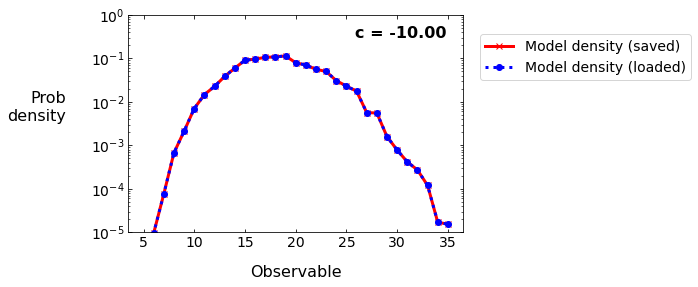

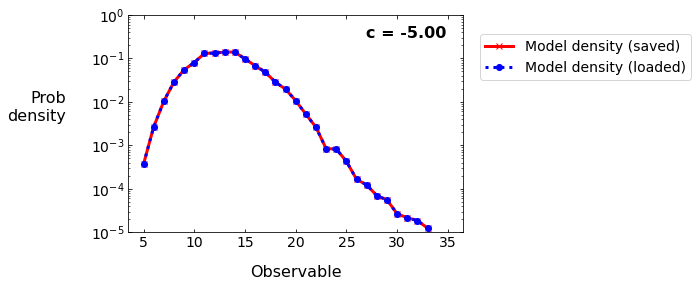

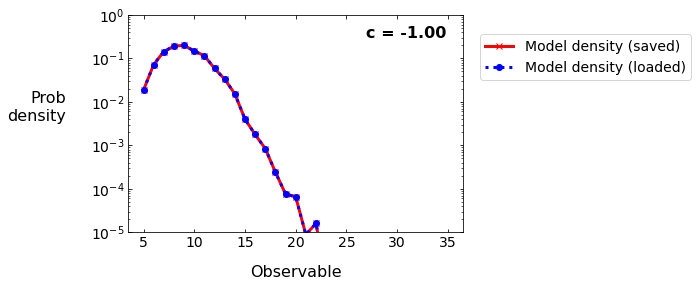

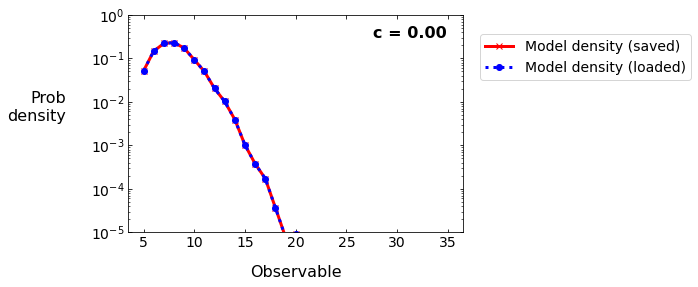

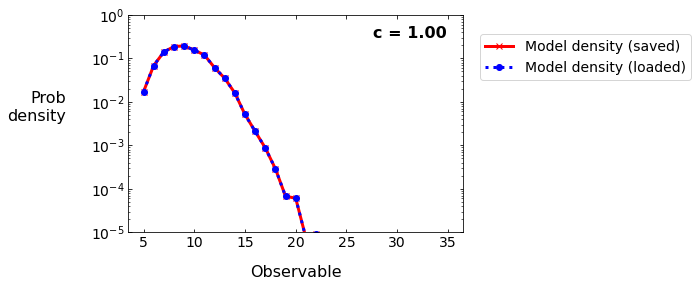

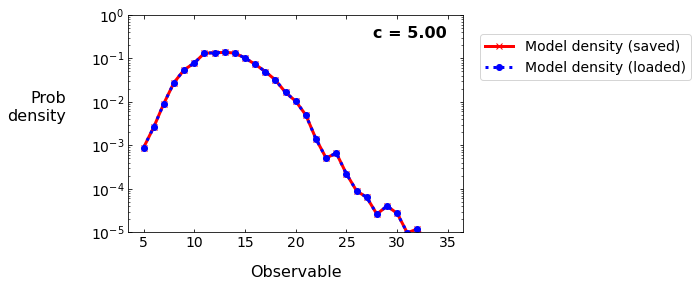

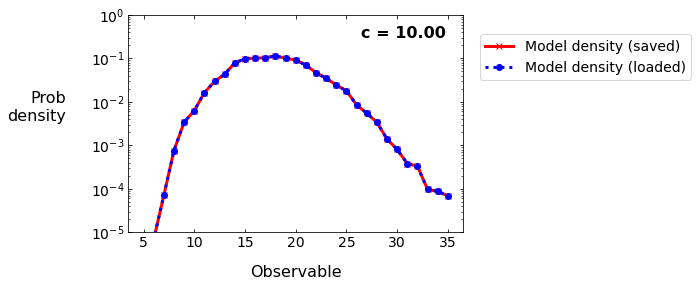

In [17]:
#  Plot trained model to make sure it learned something sensible

for c in sorted(c_vals) :
    fig = plt.figure(figsize=(6, 4))
    ax  = fig.add_subplot(1, 1, 1)
    eval_pts = np.linspace(x_min, x_max, 1+int(x_max-x_min)).reshape([-1,1])
    pred_pts_orig   = density_model       .evaluate(c, eval_pts).flatten()
    pred_pts_loaded = density_model_loaded.evaluate(c, eval_pts).flatten()
    ax.plot(eval_pts, pred_pts_orig  , "x-", lw=3, c="r", label="Model density (saved)")
    ax.plot(eval_pts, pred_pts_loaded, "o:", lw=3, c="b", label="Model density (loaded)")
    ax.set_yscale("log")
    ax.set_ylim([1e-5, 1])
    ax.text(0.95, 0.95, f"c = {c:.2f}", weight="bold", transform=ax.transAxes, fontsize=16, ha="right", va="top")
    ax.set_xlabel("Observable", labelpad=15, fontsize=16)
    ax.set_ylabel("Prob\ndensity", labelpad=25, ha="right", fontsize=16, rotation=0)
    ax.tick_params(which="both", axis="both", direction="in", labelsize=14, right=True, top=True)
    ax.legend(loc=(1.05, 0.7), fontsize=14)
    plt.show()